# Лабораторная работа 1. Классические методы построения рекомендаций.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shashist/recsys-course/blob/main/homeworks/hw_01/rs_hw01.ipynb)

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit. Пожалуйста, посмотрите [документацию](https://benfred.github.io/implicit/api/models/recommender_base.html) и примеры использования на [github](https://github.com/benfred/implicit), чтобы лучше разобраться с форматом входных данных.

Вопросы по заданию можно писать в чат курса. Ссылка на форму для отправки решений будет дана в чате.

In [127]:
!pip install optuna

In [128]:
!pip install implicit

In [129]:
!pip install rs-datasets

In [181]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

import implicit
from implicit.als import AlternatingLeastSquares

from copy import deepcopy
from tqdm import tqdm

from implicit.nearest_neighbours import BM25Recommender
import optuna

In [182]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [183]:
from rs_datasets import MovieLens

In [184]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [185]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [186]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


In [187]:
get_log_info(reviews)

Длина лога = 1000209,
количество пользователей = 6040,
количество объектов = 3706


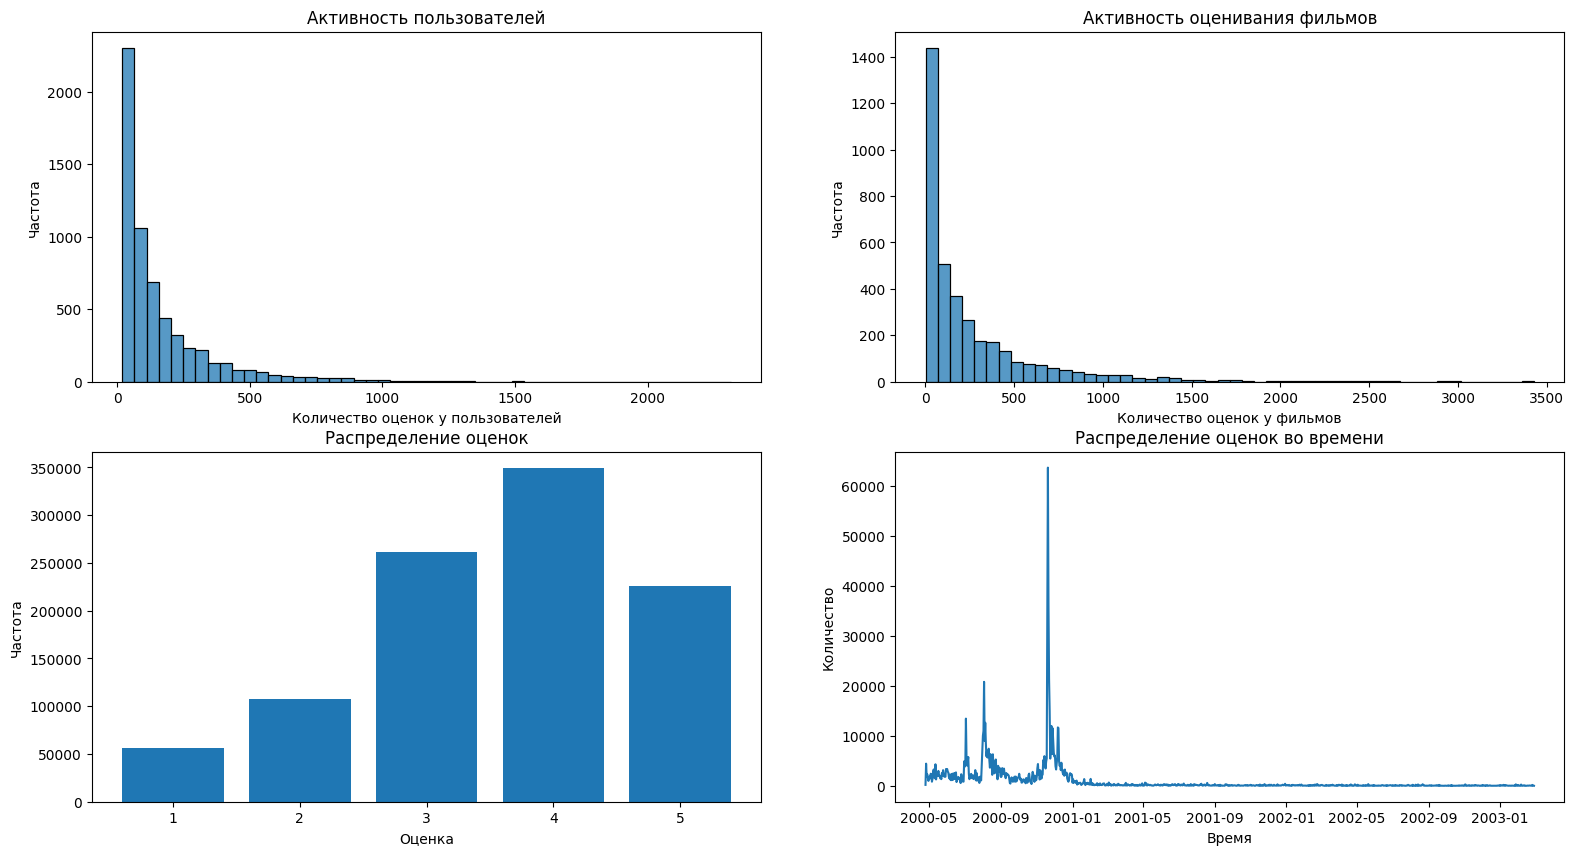

In [188]:
fig, axs = plt.subplots(2,2, figsize=(19,10))

ax = axs[0, 0]
sns.histplot(reviews.groupby('user_id').count()['item_id'], bins=50, ax=ax)
ax.set_title('Активность пользователей')
ax.set_xlabel('Количество оценок у пользователей')
ax.set_ylabel('Частота')

ax = axs[0, 1]
sns.histplot(reviews.groupby('item_id').count()['user_id'], bins=50, ax=ax)
ax.set_title('Активность оценивания фильмов')
ax.set_xlabel('Количество оценок у фильмов')
ax.set_ylabel('Частота')

ax = axs[1, 0]
ax.bar([1,2,3,4,5], reviews.groupby('relevance').count()['user_id'])
ax.set_title('Распределение оценок')
ax.set_xlabel('Оценка')
ax.set_ylabel('Частота')

ax = axs[1, 1]
reviews["date"] = reviews["timestamp"].dt.date
ax.plot(reviews.groupby("date").size().index, reviews.groupby("date").size().values)
ax.set_title('Распределение оценок во времени')
ax.set_xlabel('Время')
ax.set_ylabel('Количество')

plt.show()

Таким образом, по построенным графикам видно, что большинство пользователей ставят мало оценок на фильмы и существует множество фильмов, которые имеют всего несколько отзывов -- люди просто не хотят ставить оценки. При этом чаще всего фильмам ставят оценку 4, а реже всего -- 1. Видимо, мы работаем не с самой негативной аудиторией, но возможно для многих людей оценка 4 в этом контексте -- уже знак, что фильм не понравился. Во временной зависимости мы видим, что есть 3 пика, где много людей резко начали ставить оценки, что может быть связано просто с популярностью сервиса.

In [189]:
rpt = reviews[(reviews['date'] > pd.to_datetime('20000601').date()) & (reviews['date'] < pd.to_datetime('20010101').date())]

In [190]:
rpt.item_id.value_counts()[:15]

,count
item_id,
2858,3045
1196,2545
260,2534
1210,2480
480,2336
589,2307
2028,2297
1270,2218
1580,2207


item_id 2858 - Красота по Американски. Очень популрный фильм конца 1999 года.

In [191]:
rpt.user_id.value_counts()

,count
user_id,
4169,2029
1680,1850
889,1518
1181,1487
4277,1443
...,...
5487,1
5664,1
5668,1


Но в итоге по ощущению присутствие 3 пиков не связана с какими-то бурными новинками, а просто с популярностью самих отзывов как таковых.

In [192]:
reviews = reviews.drop('date', axis=1)

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [193]:
train = reviews[reviews["timestamp"] < pd.to_datetime("20001201")]
val = reviews[(reviews["timestamp"] >= pd.to_datetime("20001201")) & (reviews["timestamp"] <= pd.to_datetime("20001231"))]
val = val[val['relevance'] > 3]
train_users = set(train["user_id"])
val = val[val["user_id"].isin(train_users)]

In [194]:
val.shape[0]

14790

In [195]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

In [196]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [197]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


In [198]:
train['relevance'] = train['relevance'].astype(float)

<ipython-input-198-d0ac5a6645a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype(float)


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [199]:
%%time
np.random.seed(SEED)

unique_users = val["user_id"].unique()
unique_items = set(reviews["item_id"].unique())
watched_items_by_user = train.groupby("user_id")["item_id"].apply(set).to_dict()
recommendations = []

for user in unique_users:
    watched_items = watched_items_by_user.get(user, set())
    candidate_items = list(unique_items - watched_items)

    if len(candidate_items) < 20:
        print('Недостаточный выбор фильмов')
        sampled_items = candidate_items
    else:
        sampled_items = np.random.choice(candidate_items, 20, replace=False)

    for item in sampled_items:
        recommendations.append((user, item, np.random.choice([1, 2, 3, 4, 5])))

random_pred = pd.DataFrame(recommendations, columns=["user_id", "item_id", "relevance"])

CPU times: user 800 ms, sys: 38.9 ms, total: 838 ms
Wall time: 817 ms


In [200]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [201]:
random_pred.head(1)

,user_id,item_id,relevance
0,670,1394,4


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [202]:
import math

In [203]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    DCG = np.sum(np.isin(row.pred_list[:k], row.gt_list) / np.log2(np.arange(min(len(row.pred_list), k)) + 2))
    IDCG = np.sum(1 / np.log2(np.arange(min(len(row.gt_list), k)) + 2))
    return DCG / IDCG if IDCG != 0 else 0


In [204]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [205]:
ngcg = 0
for user_id in random_pred['user_id'].unique():
    pred_list = random_pred[random_pred['user_id'] == user_id].item_id.to_list()
    gt_list = val[val['user_id'] == user_id].item_id.to_list()
    ngcg_oneuser = ndcg_user(pd.Series({'user_id': user_id, 'pred_list': pred_list, 'gt_list': gt_list}), k=20)
    ngcg += ngcg_oneuser
all_ngcg = ngcg / len(random_pred['user_id'].unique())

In [206]:
print(all_ngcg)

0.008849688328830123


### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [207]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        total_users = log['user_id'].nunique()
        self.information = dict(-np.log2(log.groupby("item_id").count().user_id / total_users))
        self.default_value = np.log2(total_users)

    def __call__(self, pred, k):
        surprisal = 0
        n_users_pred = pred.user_id.nunique()

        for user_id in pred.user_id.unique():
            for item_id in pred[pred.user_id == user_id].item_id[:k]:
                surprisal += self.information.get(item_id, self.default_value)

        return surprisal / (n_users_pred * k * self.default_value)

In [208]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [209]:
def coverage(pred, k, all_items=train['item_id']):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)


def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

In [210]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user



def leave_top_k(pred: pd.DataFrame,
                 k: int=K,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [211]:
def measure(pred, true, train, k, name, df=None):
    if df is None:
        df = pd.DataFrame(columns=['hit_rate@K', 'coverage@K', 'Surprisal', 'nDCG@K'])
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'coverage@K'] = coverage(pred=pred, k=k)
    df.loc[name, 'Surprisal'] = Surprisal(train)(pred, k)
    ngcg = 0
    for user_id in pred['user_id'].unique():
        pred_list = pred[pred['user_id'] == user_id].item_id.to_list()
        gt_list = true[true['user_id'] == user_id].item_id.to_list()
        ngcg_oneuser = ndcg_user(pd.Series({'user_id': user_id, 'pred_list': pred_list, 'gt_list': gt_list}), k=k)
        ngcg += ngcg_oneuser
    all_ngcg = ngcg / len(pred['user_id'].unique())
    df.loc[name, 'nDCG@K'] = all_ngcg
    return df

In [212]:
rec_data = measure(random_pred, val, train, 20, 'Baseline')
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885


Как можно увидеть, случайное предсказание рекомендует не очень качественно, но очень разнообразно. Но для хорошего сервиса, конечно, такой метод не подойдет.

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

Во всех заданиях дальше наш код будет состоять из двух частей -- предобработка данных для корректного и быстрого обучени модели и самого обучени. Саму предобработку запишем в отдельную функцию.

In [213]:
def preproc(train, val):
    user_cat = train['user_id'].astype('category')
    item_cat = train['item_id'].astype('category')
    user_ids = user_cat.cat.codes
    item_ids = item_cat.cat.codes
    user_item_matrix = csr_matrix((train['relevance'], (user_ids, item_ids)))
    val_users = val['user_id'].unique()
    user_mapping = dict(zip(user_cat.cat.categories, range(len(user_cat.cat.categories))))
    item_mapping = dict(zip(range(len(item_cat.cat.categories)), item_cat.cat.categories))
    item_mapping_rev = dict(zip(item_cat.cat.categories, range(len(item_cat.cat.categories))))
    return (user_item_matrix, val_users, user_mapping, item_mapping, item_mapping_rev)

### CosineRecommender

Для начала разберемся с CosineRecommender -- построим график зависимости метрик от парметра K.

In [214]:
user_item_matrix, val_users, user_mapping, item_mapping, _ = preproc(train, val)

In [215]:
Ks = np.concat([np.array([10, 15, 20, 25, 30]), np.arange(30, 600, 40)])
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
for K in Ks:
    model = implicit.nearest_neighbours.CosineRecommender(K=K)
    model.fit(user_item_matrix)
    recommendations = []
    for user in tqdm(val_users):
        user_idx = user_mapping[user]
        recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val, train, 20, 'CosineRecommender')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006657838821411133 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 6978.65it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005986213684082031 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 6640.02it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0054285526275634766 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 6521.60it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00537419319152832 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2063.20it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00525975227355957 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1864.71it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005899667739868164 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2961.01it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005959749221801758 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2644.90it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005232572555541992 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2081.58it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01357126235961914 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1128.49it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005948781967163086 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1616.23it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005433082580566406 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1738.51it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005906820297241211 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1270.92it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005581855773925781 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1461.31it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005183696746826172 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1891.81it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005488395690917969 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1964.94it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005305767059326172 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1696.51it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005333900451660156 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1867.01it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005923032760620117 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1536.50it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0054972171783447266 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1571.75it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005502462387084961 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1474.64it/s]


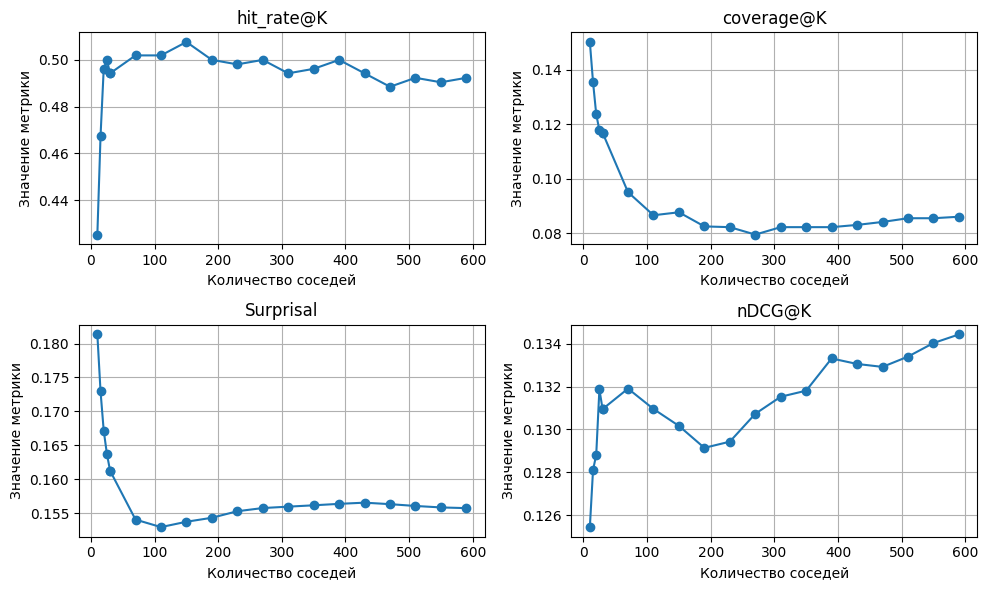

In [216]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(Ks, values, marker='o')
    ax.set_xlabel("Количество соседей")
    ax.set_ylabel("Значение метрики")
    ax.set_title(key)
    ax.grid()
plt.tight_layout()
plt.show()

In [217]:
max_K_cos = np.argmax(metrics['nDCG@K'])
cos_metrics = {'hit_rate@K' : metrics['hit_rate@K'][max_K_cos],
               'coverage@K' : metrics['coverage@K'][max_K_cos],
               'Surprisal' : metrics['Surprisal'][max_K_cos],
               'nDCG@K' : metrics['nDCG@K'][max_K_cos]}
rec_data.loc["CosineRecommender"] = cos_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443


Проанализируем полученные результаты.

С увеличением количества соседей метрики Coverage и Surprisal падают. Модель запоминает все больше соседей и диапазон подходящий для рекомендаций фильмов сужается. Метрика nDCG растет - чем больше соседей запомнила модель, тем более похожие предсказания она сделает. Метрика HitRate растет, потому что растет вариация выбора модели.

### TF-IDF

Рассматривае каждый фильма как документ, а каждого пользователя - как термин в этих документах. Идея TF-IDF: TF - частота item в данных, а IDF - логарифм обратной частоты. Таким образом, мы учитываем активных пользователей сильнее, а неизбирательных пользователей меньше.

In [218]:
train_tfidf = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_tfidf = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_tfidf = val_tfidf[val_tfidf['relevance'] > 3]
train_users_tfidf = set(train_tfidf["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_tfidf)]
train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
user_item_matrix_tfidf, val_users_tfidf, user_mapping_tfidf, item_mapping_tfidf, _ = preproc(train_tfidf, val_tfidf)


def optimizing(trial):
    K = trial.suggest_int("K", 1, 500)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = implicit.nearest_neighbours.BM25Recommender(K=K)
    model.fit(user_item_matrix_tfidf)
    recommendations = []
    for user in tqdm(val_users_tfidf):
        user_idx = user_mapping_tfidf[user]
        recs = model.recommend(user_idx, user_item_matrix_tfidf[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_tfidf[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_tfidf, train_tfidf, 20, 'TF-IDF')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=20, show_progress_bar=True)

<ipython-input-218-696917c686ca>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
[I 2025-03-24 19:39:39,020] A new study created in memory with name: no-name-bd764f11-9587-4fd6-ab13-299c493973c5


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004964113235473633 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3957.24it/s]


[I 2025-03-24 19:39:40,727] Trial 0 finished with value: 0.16448663349359763 and parameters: {'K': 107}. Best is trial 0 with value: 0.16448663349359763.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004884481430053711 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1630.34it/s]


[I 2025-03-24 19:39:43,480] Trial 1 finished with value: 0.16803563132617322 and parameters: {'K': 303}. Best is trial 1 with value: 0.16803563132617322.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0055730342864990234 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2123.75it/s]


[I 2025-03-24 19:39:45,993] Trial 2 finished with value: 0.1684503936569718 and parameters: {'K': 433}. Best is trial 2 with value: 0.1684503936569718.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004895448684692383 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2871.84it/s]


[I 2025-03-24 19:39:48,044] Trial 3 finished with value: 0.16762123356629405 and parameters: {'K': 283}. Best is trial 2 with value: 0.1684503936569718.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0048029422760009766 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2261.87it/s]


[I 2025-03-24 19:39:50,148] Trial 4 finished with value: 0.16831565488457417 and parameters: {'K': 399}. Best is trial 2 with value: 0.1684503936569718.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004724979400634766 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1757.16it/s]


[I 2025-03-24 19:39:52,281] Trial 5 finished with value: 0.16852247057511058 and parameters: {'K': 435}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0048999786376953125 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3157.28it/s]


[I 2025-03-24 19:39:54,157] Trial 6 finished with value: 0.16714204340855096 and parameters: {'K': 201}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0046844482421875 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2102.76it/s]


[I 2025-03-24 19:39:56,458] Trial 7 finished with value: 0.1636990092315632 and parameters: {'K': 101}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005721330642700195 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1849.86it/s]


[I 2025-03-24 19:39:58,905] Trial 8 finished with value: 0.16782770590869167 and parameters: {'K': 228}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004769086837768555 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3297.68it/s]


[I 2025-03-24 19:40:00,648] Trial 9 finished with value: 0.16698235547617277 and parameters: {'K': 154}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004831790924072266 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 6732.52it/s]


[I 2025-03-24 19:40:02,155] Trial 10 finished with value: 0.15374022887613542 and parameters: {'K': 23}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004738569259643555 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1731.92it/s]


[I 2025-03-24 19:40:04,304] Trial 11 finished with value: 0.1678818648343237 and parameters: {'K': 477}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004690885543823242 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1983.83it/s]


[I 2025-03-24 19:40:06,457] Trial 12 finished with value: 0.1674849351864496 and parameters: {'K': 496}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005619525909423828 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2477.15it/s]


[I 2025-03-24 19:40:08,738] Trial 13 finished with value: 0.16843112155118528 and parameters: {'K': 391}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006078958511352539 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1351.76it/s]


[I 2025-03-24 19:40:11,906] Trial 14 finished with value: 0.16652635375594996 and parameters: {'K': 370}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0047359466552734375 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2140.81it/s]


[I 2025-03-24 19:40:14,071] Trial 15 finished with value: 0.1676940652714681 and parameters: {'K': 445}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004511594772338867 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2582.27it/s]


[I 2025-03-24 19:40:16,154] Trial 16 finished with value: 0.16744543558814548 and parameters: {'K': 332}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004784345626831055 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1990.13it/s]


[I 2025-03-24 19:40:18,303] Trial 17 finished with value: 0.1681914490164178 and parameters: {'K': 418}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004510402679443359 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1990.83it/s]


[I 2025-03-24 19:40:20,815] Trial 18 finished with value: 0.16794920050801684 and parameters: {'K': 345}. Best is trial 5 with value: 0.16852247057511058.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0074045658111572266 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 476.51it/s]


[I 2025-03-24 19:40:26,622] Trial 19 finished with value: 0.16814043489884503 and parameters: {'K': 440}. Best is trial 5 with value: 0.16852247057511058.


In [219]:
study.best_params

{'K': 435}

In [220]:
K = study.best_params['K']
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = implicit.nearest_neighbours.TFIDFRecommender(K=K)
model.fit(user_item_matrix)
recommendations = []
for user in tqdm(val_users):
    user_idx = user_mapping[user]
    recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val, train, 20, 'TF-IDF')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.018996477127075195 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 912.50it/s] 


In [221]:
IFIDF_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["TF-IDF"] = IFIDF_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.511494,0.091753,0.152559,0.13578


### TF-IDF on positive

Далее отделим все положительные метки в train.

In [222]:
train_tfidf = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_tfidf = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_tfidf = val_tfidf[val_tfidf['relevance'] > 3]
train_users_tfidf = set(train_tfidf["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_tfidf)]
train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
train_positive = train_tfidf[train_tfidf['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_tfidf, user_mapping_tfidf, item_mapping_tfidf, item_mapping_rev_tfidf = preproc(train_positive, val_tfidf)

def optimizing(trial):
    K = trial.suggest_int("K", 1, 500)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = implicit.nearest_neighbours.BM25Recommender(K=K)
    model.fit(user_item_matrix_positive)
    recommendations = []
    for user in tqdm(val_users_tfidf):
        user_idx = user_mapping_tfidf[user]

        user_interactions = train_tfidf[train_tfidf['user_id'] == user]
        user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
        seen_items = set(user_interactions['item_id'].map(item_mapping_rev_tfidf).values)

        recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_tfidf[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_tfidf, train_positive, 20, 'TF-IDF on positive')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=20, show_progress_bar=True)

<ipython-input-222-63e39c18ea74>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
[I 2025-03-24 19:40:30,745] A new study created in memory with name: no-name-d3b0d22d-1001-493f-8df9-bdae76e6c3b7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.003912925720214844 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.57it/s]


[I 2025-03-24 19:40:34,802] Trial 0 finished with value: 0.15401580437153645 and parameters: {'K': 396}. Best is trial 0 with value: 0.15401580437153645.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0027213096618652344 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 99.07it/s] 


[I 2025-03-24 19:40:40,414] Trial 1 finished with value: 0.15479851401313083 and parameters: {'K': 450}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0029740333557128906 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 153.61it/s]


[I 2025-03-24 19:40:44,534] Trial 2 finished with value: 0.15478422653283747 and parameters: {'K': 275}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002790689468383789 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 150.87it/s]


[I 2025-03-24 19:40:48,593] Trial 3 finished with value: 0.15368119272709996 and parameters: {'K': 191}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006210803985595703 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 124.04it/s]


[I 2025-03-24 19:40:53,372] Trial 4 finished with value: 0.15444715421175942 and parameters: {'K': 332}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0029191970825195312 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 149.87it/s]


[I 2025-03-24 19:40:57,333] Trial 5 finished with value: 0.15405338764807114 and parameters: {'K': 303}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0029664039611816406 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 147.55it/s]


[I 2025-03-24 19:41:01,749] Trial 6 finished with value: 0.1545507835017065 and parameters: {'K': 466}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0030748844146728516 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 131.16it/s]


[I 2025-03-24 19:41:05,912] Trial 7 finished with value: 0.12928631255665274 and parameters: {'K': 6}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0026869773864746094 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 150.95it/s]


[I 2025-03-24 19:41:09,947] Trial 8 finished with value: 0.15439007280000552 and parameters: {'K': 437}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0028045177459716797 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 147.27it/s]


[I 2025-03-24 19:41:14,066] Trial 9 finished with value: 0.15424090389056647 and parameters: {'K': 200}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005524158477783203 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 121.54it/s]


[I 2025-03-24 19:41:18,574] Trial 10 finished with value: 0.15407592795122335 and parameters: {'K': 78}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002714872360229492 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 147.94it/s]


[I 2025-03-24 19:41:22,610] Trial 11 finished with value: 0.15436856337374774 and parameters: {'K': 355}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002993345260620117 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.65it/s]


[I 2025-03-24 19:41:26,829] Trial 12 finished with value: 0.15471007112725368 and parameters: {'K': 249}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004997730255126953 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 126.98it/s]


[I 2025-03-24 19:41:31,794] Trial 13 finished with value: 0.1545263149208916 and parameters: {'K': 482}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002729654312133789 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.26it/s]


[I 2025-03-24 19:41:35,585] Trial 14 finished with value: 0.15425923123934834 and parameters: {'K': 128}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002682209014892578 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 148.07it/s]


[I 2025-03-24 19:41:39,657] Trial 15 finished with value: 0.1542297450600192 and parameters: {'K': 264}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0048444271087646484 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 122.91it/s]


[I 2025-03-24 19:41:44,632] Trial 16 finished with value: 0.15402584478531023 and parameters: {'K': 397}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0029649734497070312 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 145.29it/s]


[I 2025-03-24 19:41:48,736] Trial 17 finished with value: 0.15468255769102396 and parameters: {'K': 385}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002833127975463867 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 150.50it/s]


[I 2025-03-24 19:41:52,745] Trial 18 finished with value: 0.1542269833170211 and parameters: {'K': 157}. Best is trial 1 with value: 0.15479851401313083.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0034329891204833984 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 124.24it/s]


[I 2025-03-24 19:41:57,674] Trial 19 finished with value: 0.15415463352628142 and parameters: {'K': 291}. Best is trial 1 with value: 0.15479851401313083.


In [223]:
study.best_params

{'K': 450}

In [224]:
K = study.best_params['K']

train_positive = train[train['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_positive = val[val["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_positive, user_mapping_positive, item_mapping_positive, item_mapping_rev_positive = preproc(train_positive, val_positive)

metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = implicit.nearest_neighbours.BM25Recommender(K=K)
model.fit(user_item_matrix_positive)
recommendations = []
for user in tqdm(val_users_positive):
    user_idx = user_mapping_positive[user]

    user_interactions = train[train['user_id'] == user]
    user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
    seen_items = set(user_interactions['item_id'].map(item_mapping_rev_positive).values)

    recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping_positive[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val_positive, train_positive, 20, 'TF-IDF on positive')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0031571388244628906 seconds
  warnings.warn(


  0%|          | 0/3468 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.37it/s]


In [225]:
IFIDF_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["TF-IDF on positive"] = IFIDF_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.511494,0.091753,0.152559,0.13578
TF-IDF on positive,0.804598,0.059257,0.167818,0.126505


Как мы видим, мы не улучшили нашу основную метрику nDCG@K. Возможно это связано с тем, что разбиения для валидации оказалось не таким хорошим. При это метрики, например, hit_rate@K сильно выросли, а значит мы попадаем чаще хотя бы раз.

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

### ALS

In [226]:
train_als = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_als = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_als = val_als[val_als['relevance'] > 3]
train_users_als = set(train_als["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_als)]
train_als['relevance'] = train_als['relevance'].astype(float)

user_item_matrix_als, val_users_als, user_mapping_als, item_mapping_als, _ = preproc(train_als, val_als)

def optimizing(trial):
    factors = trial.suggest_int("factors", 1, 50)
    regularization = trial.suggest_float("regularization", 1e-10, 0.1, log=True)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix_als)
    recommendations = []
    for user in tqdm(val_users_als):
        user_idx = user_mapping_als[user]
        recs = model.recommend(user_idx, user_item_matrix_als[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_als[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_als, train_als, 20, 'ALS')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=70, show_progress_bar=True)

<ipython-input-226-2168f8a44642>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_als['relevance'] = train_als['relevance'].astype(float)
[I 2025-03-24 19:42:04,794] A new study created in memory with name: no-name-425afc33-bb37-44ce-b308-e430fc91a567


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3166.42it/s]


[I 2025-03-24 19:42:15,338] Trial 0 finished with value: 0.12052552281604342 and parameters: {'factors': 49, 'regularization': 4.6487288486489785e-06}. Best is trial 0 with value: 0.12052552281604342.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2450.95it/s]


[I 2025-03-24 19:42:19,993] Trial 1 finished with value: 0.15081605048107954 and parameters: {'factors': 8, 'regularization': 1.8208323191012827e-06}. Best is trial 1 with value: 0.15081605048107954.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3711.23it/s]


[I 2025-03-24 19:42:29,454] Trial 2 finished with value: 0.13833411656001668 and parameters: {'factors': 25, 'regularization': 1.8627740911362955e-08}. Best is trial 1 with value: 0.15081605048107954.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3401.65it/s]


[I 2025-03-24 19:42:38,243] Trial 3 finished with value: 0.12153188002839556 and parameters: {'factors': 39, 'regularization': 1.0996628110586196e-07}. Best is trial 1 with value: 0.15081605048107954.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4683.41it/s]


[I 2025-03-24 19:42:42,730] Trial 4 finished with value: 0.15126389017955238 and parameters: {'factors': 9, 'regularization': 7.749640941230772e-06}. Best is trial 4 with value: 0.15126389017955238.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3928.64it/s]


[I 2025-03-24 19:42:53,729] Trial 5 finished with value: 0.1309118396291031 and parameters: {'factors': 30, 'regularization': 4.134199348039655e-06}. Best is trial 4 with value: 0.15126389017955238.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4785.96it/s]


[I 2025-03-24 19:42:59,073] Trial 6 finished with value: 0.1478345264384433 and parameters: {'factors': 14, 'regularization': 1.3237498789652368e-06}. Best is trial 4 with value: 0.15126389017955238.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3360.92it/s]


[I 2025-03-24 19:43:07,886] Trial 7 finished with value: 0.12468726002192085 and parameters: {'factors': 41, 'regularization': 4.230883063309867e-07}. Best is trial 4 with value: 0.15126389017955238.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3924.43it/s]


[I 2025-03-24 19:43:15,911] Trial 8 finished with value: 0.12575106310641992 and parameters: {'factors': 34, 'regularization': 6.760005976210865e-05}. Best is trial 4 with value: 0.15126389017955238.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4319.68it/s]


[I 2025-03-24 19:43:20,869] Trial 9 finished with value: 0.1503673041612994 and parameters: {'factors': 13, 'regularization': 0.00034855096853961156}. Best is trial 4 with value: 0.15126389017955238.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4897.46it/s]


[I 2025-03-24 19:43:24,216] Trial 10 finished with value: 0.16959372968891467 and parameters: {'factors': 2, 'regularization': 0.05629967999097849}. Best is trial 10 with value: 0.16959372968891467.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2216.76it/s]


[I 2025-03-24 19:43:28,741] Trial 11 finished with value: 0.16992487069363657 and parameters: {'factors': 2, 'regularization': 0.08106027332607214}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4807.74it/s]


[I 2025-03-24 19:43:31,112] Trial 12 finished with value: 0.16410561182794017 and parameters: {'factors': 1, 'regularization': 0.09616230431293774}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4216.42it/s]


[I 2025-03-24 19:43:33,474] Trial 13 finished with value: 0.16410561182794017 and parameters: {'factors': 1, 'regularization': 0.05136324756208282}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4198.42it/s]


[I 2025-03-24 19:43:43,035] Trial 14 finished with value: 0.1419570153255234 and parameters: {'factors': 21, 'regularization': 0.003196673418315709}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4204.53it/s]


[I 2025-03-24 19:43:51,013] Trial 15 finished with value: 0.14001459199733632 and parameters: {'factors': 20, 'regularization': 1.0211162666810955e-10}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4350.69it/s]


[I 2025-03-24 19:43:56,515] Trial 16 finished with value: 0.14900109652903878 and parameters: {'factors': 8, 'regularization': 0.0036299387850060355}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4993.02it/s]


[I 2025-03-24 19:43:58,803] Trial 17 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 0.0021762919832076415}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4368.98it/s]


[I 2025-03-24 19:44:04,660] Trial 18 finished with value: 0.14725487073470053 and parameters: {'factors': 16, 'regularization': 0.01588239248067875}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4953.15it/s]


[I 2025-03-24 19:44:09,860] Trial 19 finished with value: 0.1521456475197668 and parameters: {'factors': 6, 'regularization': 0.00013517185106120278}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3786.71it/s]


[I 2025-03-24 19:44:17,643] Trial 20 finished with value: 0.14001389153722246 and parameters: {'factors': 19, 'regularization': 5.019872027308468e-09}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2490.76it/s]


[I 2025-03-24 19:44:22,339] Trial 21 finished with value: 0.16250423033117878 and parameters: {'factors': 3, 'regularization': 0.002369846066205884}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3761.35it/s]


[I 2025-03-24 19:44:26,235] Trial 22 finished with value: 0.1663339470435251 and parameters: {'factors': 5, 'regularization': 0.013081373060264677}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4405.00it/s]


[I 2025-03-24 19:44:30,890] Trial 23 finished with value: 0.14800463420175786 and parameters: {'factors': 11, 'regularization': 0.015604736337060568}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 5044.65it/s]


[I 2025-03-24 19:44:35,756] Trial 24 finished with value: 0.1650177020786053 and parameters: {'factors': 4, 'regularization': 0.017683121387469865}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4591.53it/s]


[I 2025-03-24 19:44:39,623] Trial 25 finished with value: 0.16667124956281093 and parameters: {'factors': 5, 'regularization': 0.0005907498008334876}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3389.15it/s]


[I 2025-03-24 19:44:44,241] Trial 26 finished with value: 0.15302855516166003 and parameters: {'factors': 10, 'regularization': 0.000520822898638848}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4955.09it/s]


[I 2025-03-24 19:44:51,324] Trial 27 finished with value: 0.14192529506490995 and parameters: {'factors': 16, 'regularization': 4.2842860508073455e-05}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4587.60it/s]


[I 2025-03-24 19:44:55,388] Trial 28 finished with value: 0.15739814394154442 and parameters: {'factors': 6, 'regularization': 0.0006776670311658263}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2855.24it/s]


[I 2025-03-24 19:45:05,729] Trial 29 finished with value: 0.12000137252055573 and parameters: {'factors': 49, 'regularization': 0.0814217142899474}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2259.87it/s]


[I 2025-03-24 19:45:14,845] Trial 30 finished with value: 0.11957674723436999 and parameters: {'factors': 44, 'regularization': 2.6857417941840713e-05}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4503.78it/s]


[I 2025-03-24 19:45:18,717] Trial 31 finished with value: 0.16655399113047736 and parameters: {'factors': 5, 'regularization': 0.012633315700021111}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4773.23it/s]


[I 2025-03-24 19:45:22,899] Trial 32 finished with value: 0.15537584086020714 and parameters: {'factors': 7, 'regularization': 0.007259095289419579}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4516.93it/s]


[I 2025-03-24 19:45:28,958] Trial 33 finished with value: 0.14814669418199877 and parameters: {'factors': 12, 'regularization': 0.03446915679866566}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 5057.81it/s]


[I 2025-03-24 19:45:32,658] Trial 34 finished with value: 0.16436843635055284 and parameters: {'factors': 4, 'regularization': 0.0008146210088483363}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3911.31it/s]


[I 2025-03-24 19:45:42,948] Trial 35 finished with value: 0.1380606607748309 and parameters: {'factors': 26, 'regularization': 0.005473753062683293}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4462.22it/s]


[I 2025-03-24 19:45:47,412] Trial 36 finished with value: 0.1498676604636196 and parameters: {'factors': 8, 'regularization': 0.08988902373209456}. Best is trial 11 with value: 0.16992487069363657.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4321.06it/s]


[I 2025-03-24 19:45:50,999] Trial 37 finished with value: 0.17176354657019166 and parameters: {'factors': 3, 'regularization': 0.00016131104617541356}. Best is trial 37 with value: 0.17176354657019166.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2678.89it/s]


[I 2025-03-24 19:45:54,394] Trial 38 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 0.0012754747213371438}. Best is trial 37 with value: 0.17176354657019166.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4512.42it/s]


[I 2025-03-24 19:45:59,094] Trial 39 finished with value: 0.15192671519882944 and parameters: {'factors': 9, 'regularization': 1.025691153919767e-05}. Best is trial 37 with value: 0.17176354657019166.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2193.60it/s]


[I 2025-03-24 19:46:06,080] Trial 40 finished with value: 0.14530137386788322 and parameters: {'factors': 15, 'regularization': 0.00017162018011953828}. Best is trial 37 with value: 0.17176354657019166.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4109.58it/s]


[I 2025-03-24 19:46:10,385] Trial 41 finished with value: 0.16805772088638735 and parameters: {'factors': 3, 'regularization': 0.03652884246095984}. Best is trial 37 with value: 0.17176354657019166.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4920.92it/s]


[I 2025-03-24 19:46:13,929] Trial 42 finished with value: 0.16086326109011348 and parameters: {'factors': 3, 'regularization': 0.02938883999995814}. Best is trial 37 with value: 0.17176354657019166.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4964.60it/s]


[I 2025-03-24 19:46:17,504] Trial 43 finished with value: 0.17452079976641058 and parameters: {'factors': 3, 'regularization': 1.2889185990646734e-06}. Best is trial 43 with value: 0.17452079976641058.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 838.15it/s]


[I 2025-03-24 19:46:22,652] Trial 44 finished with value: 0.17528622945375885 and parameters: {'factors': 3, 'regularization': 5.935221311387679e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2920.74it/s]


[I 2025-03-24 19:46:29,412] Trial 45 finished with value: 0.12503724089000615 and parameters: {'factors': 34, 'regularization': 2.9117362407579235e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2701.80it/s]


[I 2025-03-24 19:46:35,357] Trial 46 finished with value: 0.1524683063521187 and parameters: {'factors': 10, 'regularization': 4.25603161035341e-08}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4632.37it/s]


[I 2025-03-24 19:46:37,621] Trial 47 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 2.069129277547025e-06}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4828.77it/s]


[I 2025-03-24 19:46:42,541] Trial 48 finished with value: 0.14782683697985766 and parameters: {'factors': 12, 'regularization': 3.5187785635287536e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2185.54it/s]


[I 2025-03-24 19:46:47,917] Trial 49 finished with value: 0.15540830310505363 and parameters: {'factors': 7, 'regularization': 1.182645855047554e-06}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3904.60it/s]


[I 2025-03-24 19:46:56,697] Trial 50 finished with value: 0.13855200531890208 and parameters: {'factors': 24, 'regularization': 3.365643696029986e-09}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2275.18it/s]


[I 2025-03-24 19:47:01,265] Trial 51 finished with value: 0.16966345609710506 and parameters: {'factors': 2, 'regularization': 1.1236442036871418e-05}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4993.66it/s]


[I 2025-03-24 19:47:04,834] Trial 52 finished with value: 0.14712018069451577 and parameters: {'factors': 3, 'regularization': 1.8836828377064125e-05}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4122.76it/s]


[I 2025-03-24 19:47:07,133] Trial 53 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 5.674932750621438e-06}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3692.53it/s]


[I 2025-03-24 19:47:11,840] Trial 54 finished with value: 0.14874336901871413 and parameters: {'factors': 8, 'regularization': 1.2964316111596992e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3975.99it/s]


[I 2025-03-24 19:47:16,144] Trial 55 finished with value: 0.14610179455019717 and parameters: {'factors': 3, 'regularization': 1.0901496524862008e-06}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2878.34it/s]


[I 2025-03-24 19:47:20,284] Trial 56 finished with value: 0.1565374000869903 and parameters: {'factors': 6, 'regularization': 2.75509734058948e-06}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4363.70it/s]


[I 2025-03-24 19:47:23,683] Trial 57 finished with value: 0.1707786127116364 and parameters: {'factors': 2, 'regularization': 7.338350077121484e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4980.70it/s]


[I 2025-03-24 19:47:29,146] Trial 58 finished with value: 0.16524563225569314 and parameters: {'factors': 4, 'regularization': 6.118927702684531e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4946.99it/s]


[I 2025-03-24 19:47:34,652] Trial 59 finished with value: 0.1494653940684349 and parameters: {'factors': 9, 'regularization': 9.701724542020107e-08}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2302.27it/s]


[I 2025-03-24 19:47:39,595] Trial 60 finished with value: 0.15449468408305148 and parameters: {'factors': 6, 'regularization': 1.0620838708154529e-05}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 5183.79it/s]


[I 2025-03-24 19:47:43,178] Trial 61 finished with value: 0.16619530699940252 and parameters: {'factors': 2, 'regularization': 8.852180820500451e-05}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4625.18it/s]


[I 2025-03-24 19:47:46,595] Trial 62 finished with value: 0.16542957798689714 and parameters: {'factors': 2, 'regularization': 4.097862287719722e-06}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4433.44it/s]


[I 2025-03-24 19:47:50,653] Trial 63 finished with value: 0.16784268946286077 and parameters: {'factors': 5, 'regularization': 1.4513659286943569e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2314.26it/s]


[I 2025-03-24 19:47:54,116] Trial 64 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 8.366385799513147e-07}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4149.99it/s]


[I 2025-03-24 19:47:58,431] Trial 65 finished with value: 0.15337756702071342 and parameters: {'factors': 7, 'regularization': 3.822827930744616e-08}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3250.59it/s]


[I 2025-03-24 19:48:02,270] Trial 66 finished with value: 0.16526947345679002 and parameters: {'factors': 4, 'regularization': 0.00027754722960928515}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3129.19it/s]


[I 2025-03-24 19:48:12,427] Trial 67 finished with value: 0.12527195433588034 and parameters: {'factors': 47, 'regularization': 1.948846276509192e-06}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2991.83it/s]


[I 2025-03-24 19:48:21,327] Trial 68 finished with value: 0.14095225634124217 and parameters: {'factors': 18, 'regularization': 7.234036461595886e-09}. Best is trial 44 with value: 0.17528622945375885.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3079.86it/s]


[I 2025-03-24 19:48:28,842] Trial 69 finished with value: 0.12544130769218512 and parameters: {'factors': 38, 'regularization': 1.8336087856723905e-05}. Best is trial 44 with value: 0.17528622945375885.


In [227]:
study.best_params

{'factors': 3, 'regularization': 5.935221311387679e-07}

In [228]:
factors, regularization = study.best_params['factors'], study.best_params['regularization']
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = AlternatingLeastSquares(factors=factors, regularization=regularization)
model.fit(user_item_matrix)
recommendations = []
for user in tqdm(val_users):
    user_idx = user_mapping[user]
    recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val, train, 20, 'ALS')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2482.52it/s]


In [229]:
ALS_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["ALS"] = ALS_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.511494,0.091753,0.152559,0.13578
TF-IDF on positive,0.804598,0.059257,0.167818,0.126505
ALS,0.545977,0.106499,0.154692,0.140348


In [236]:
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
for factors in range(3, 20):
    regularization = 5.935221311387679e-07
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix)
    recommendations = []
    for user in tqdm(val_users):
        user_idx = user_mapping[user]
        recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val, train, 20, 'ALS')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2677.83it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4726.22it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3993.62it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 5015.21it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3804.05it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3020.45it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3974.24it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4618.23it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4151.60it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4760.60it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4637.64it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4534.59it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4520.72it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3970.55it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4140.76it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4091.03it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3690.77it/s]


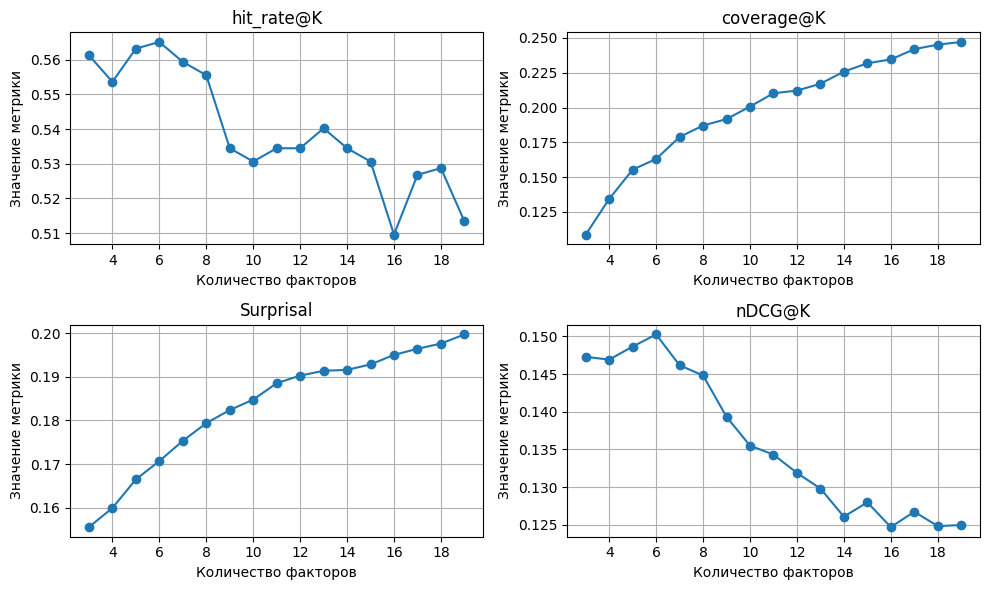

In [237]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(range(3, 20), values, marker='o')
    ax.set_xlabel("Количество факторов")
    ax.set_ylabel("Значение метрики")
    ax.set_title(key)
    ax.grid()
plt.tight_layout()
plt.show()

### ALS on positive

In [230]:
train_als = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_als = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_als = val_als[val_als['relevance'] > 3]
train_users_als = set(train_als["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_als)]
train_als['relevance'] = train_als['relevance'].astype(float)
train_positive = train_als[train_als['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_als, user_mapping_als, item_mapping_als, item_mapping_reverse_als = preproc(train_positive, val_als)

def optimizing(trial):
    factors = trial.suggest_int("factors", 5, 50)
    regularization = trial.suggest_float("regularization", 1e-6, 0.1, log=True)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix_positive)
    recommendations = []
    for user in tqdm(val_users_als):
        user_idx = user_mapping_als[user]

        user_interactions = train_als[train_als['user_id'] == user]
        user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
        seen_items = list(user_interactions['item_id'].map(item_mapping_reverse_als).values)

        recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_als[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_als, train_positive, 20, 'ALS on positive')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=70, show_progress_bar=True)

<ipython-input-230-52113b51635a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_als['relevance'] = train_als['relevance'].astype(float)
[I 2025-03-24 19:48:34,526] A new study created in memory with name: no-name-6db82f7c-2f8c-440d-9008-2f255dd0ffa5


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 153.60it/s]


[I 2025-03-24 19:48:42,917] Trial 0 finished with value: 0.16867567286463236 and parameters: {'factors': 23, 'regularization': 7.73029495763114e-06}. Best is trial 0 with value: 0.16867567286463236.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 154.39it/s]


[I 2025-03-24 19:48:52,670] Trial 1 finished with value: 0.15232632942638136 and parameters: {'factors': 38, 'regularization': 4.7078999630275695e-06}. Best is trial 0 with value: 0.16867567286463236.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 140.24it/s]


[I 2025-03-24 19:49:02,714] Trial 2 finished with value: 0.14758766322347494 and parameters: {'factors': 49, 'regularization': 1.5406145840694475e-06}. Best is trial 0 with value: 0.16867567286463236.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 159.44it/s]


[I 2025-03-24 19:49:10,867] Trial 3 finished with value: 0.16919043851700272 and parameters: {'factors': 20, 'regularization': 0.00031647769502701604}. Best is trial 3 with value: 0.16919043851700272.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 159.82it/s]


[I 2025-03-24 19:49:19,914] Trial 4 finished with value: 0.15000479707889813 and parameters: {'factors': 42, 'regularization': 0.00031949506786814843}. Best is trial 3 with value: 0.16919043851700272.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 156.45it/s]


[I 2025-03-24 19:49:29,312] Trial 5 finished with value: 0.15143291492462835 and parameters: {'factors': 44, 'regularization': 1.9985852352765517e-06}. Best is trial 3 with value: 0.16919043851700272.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 115.61it/s]


[I 2025-03-24 19:49:39,116] Trial 6 finished with value: 0.1456160219757043 and parameters: {'factors': 49, 'regularization': 1.4205776153014925e-06}. Best is trial 3 with value: 0.16919043851700272.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 154.34it/s]


[I 2025-03-24 19:49:47,035] Trial 7 finished with value: 0.17037959690676033 and parameters: {'factors': 19, 'regularization': 0.0017331153517019693}. Best is trial 7 with value: 0.17037959690676033.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 156.48it/s]


[I 2025-03-24 19:49:56,379] Trial 8 finished with value: 0.16752127112704104 and parameters: {'factors': 20, 'regularization': 0.0005882367475460779}. Best is trial 7 with value: 0.17037959690676033.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 84.64it/s]


[I 2025-03-24 19:50:05,615] Trial 9 finished with value: 0.15589801858200036 and parameters: {'factors': 33, 'regularization': 0.00043368159609875396}. Best is trial 7 with value: 0.17037959690676033.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 152.98it/s]


[I 2025-03-24 19:50:10,985] Trial 10 finished with value: 0.17218243393961982 and parameters: {'factors': 8, 'regularization': 0.010059413621542244}. Best is trial 10 with value: 0.17218243393961982.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 155.51it/s]


[I 2025-03-24 19:50:16,184] Trial 11 finished with value: 0.18226360749307116 and parameters: {'factors': 5, 'regularization': 0.0277537515672581}. Best is trial 11 with value: 0.18226360749307116.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.95it/s]


[I 2025-03-24 19:50:22,189] Trial 12 finished with value: 0.1819110294966195 and parameters: {'factors': 5, 'regularization': 0.052840841948421216}. Best is trial 11 with value: 0.18226360749307116.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 148.40it/s]


[I 2025-03-24 19:50:27,347] Trial 13 finished with value: 0.17985360556855778 and parameters: {'factors': 5, 'regularization': 0.08957394580210085}. Best is trial 11 with value: 0.18226360749307116.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 119.60it/s]


[I 2025-03-24 19:50:34,216] Trial 14 finished with value: 0.16677638802919545 and parameters: {'factors': 11, 'regularization': 0.06648235551010225}. Best is trial 11 with value: 0.18226360749307116.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 149.60it/s]


[I 2025-03-24 19:50:40,115] Trial 15 finished with value: 0.16450715916217215 and parameters: {'factors': 13, 'regularization': 0.017915864426293913}. Best is trial 11 with value: 0.18226360749307116.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 150.27it/s]


[I 2025-03-24 19:50:50,528] Trial 16 finished with value: 0.16031041656906855 and parameters: {'factors': 29, 'regularization': 0.006991408825880769}. Best is trial 11 with value: 0.18226360749307116.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 142.95it/s]


[I 2025-03-24 19:50:56,842] Trial 17 finished with value: 0.1669285778288566 and parameters: {'factors': 14, 'regularization': 7.36412450724652e-05}. Best is trial 11 with value: 0.18226360749307116.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.68it/s]


[I 2025-03-24 19:51:02,472] Trial 18 finished with value: 0.18446135933901775 and parameters: {'factors': 5, 'regularization': 0.0031446223246548266}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 148.90it/s]


[I 2025-03-24 19:51:08,524] Trial 19 finished with value: 0.16499816190446262 and parameters: {'factors': 15, 'regularization': 0.003363697187153531}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 156.31it/s]


[I 2025-03-24 19:51:18,384] Trial 20 finished with value: 0.16559243825220557 and parameters: {'factors': 26, 'regularization': 0.0014906302468129847}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 126.78it/s]


[I 2025-03-24 19:51:24,170] Trial 21 finished with value: 0.1836478338598743 and parameters: {'factors': 5, 'regularization': 0.031409748014189755}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 155.34it/s]


[I 2025-03-24 19:51:29,770] Trial 22 finished with value: 0.1749810750006892 and parameters: {'factors': 9, 'regularization': 0.023170500955229524}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 155.58it/s]


[I 2025-03-24 19:51:34,795] Trial 23 finished with value: 0.18429411528205292 and parameters: {'factors': 5, 'regularization': 0.004398741320016063}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 154.96it/s]


[I 2025-03-24 19:51:41,432] Trial 24 finished with value: 0.17113361905949995 and parameters: {'factors': 9, 'regularization': 7.376643257360599e-05}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 153.61it/s]


[I 2025-03-24 19:51:47,712] Trial 25 finished with value: 0.1672791166161961 and parameters: {'factors': 16, 'regularization': 0.005893689352880218}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.32it/s]


[I 2025-03-24 19:51:54,344] Trial 26 finished with value: 0.17007361038312813 and parameters: {'factors': 9, 'regularization': 0.001968851025522896}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.69it/s]


[I 2025-03-24 19:52:00,130] Trial 27 finished with value: 0.16646570015388362 and parameters: {'factors': 12, 'regularization': 8.813654163836784e-05}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 113.59it/s]


[I 2025-03-24 19:52:06,409] Trial 28 finished with value: 0.1833019523317749 and parameters: {'factors': 5, 'regularization': 0.0010019891793511691}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.89it/s]


[I 2025-03-24 19:52:15,707] Trial 29 finished with value: 0.15942265033390868 and parameters: {'factors': 27, 'regularization': 0.0033270521889312878}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 152.51it/s]


[I 2025-03-24 19:52:24,647] Trial 30 finished with value: 0.16551462696342262 and parameters: {'factors': 22, 'regularization': 0.00015502844495989885}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 102.40it/s]


[I 2025-03-24 19:52:31,137] Trial 31 finished with value: 0.18384588662693455 and parameters: {'factors': 7, 'regularization': 0.0010151394016827229}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 154.58it/s]


[I 2025-03-24 19:52:36,573] Trial 32 finished with value: 0.17053253141799 and parameters: {'factors': 8, 'regularization': 0.011270476570099296}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 107.52it/s]


[I 2025-03-24 19:52:43,875] Trial 33 finished with value: 0.16931033792893355 and parameters: {'factors': 16, 'regularization': 2.4634165344855102e-05}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.99it/s]


[I 2025-03-24 19:52:49,536] Trial 34 finished with value: 0.1699963250085445 and parameters: {'factors': 11, 'regularization': 0.003954068766216312}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 121.86it/s]


[I 2025-03-24 19:52:55,731] Trial 35 finished with value: 0.18396878196928237 and parameters: {'factors': 7, 'regularization': 0.0008933687775682981}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 153.39it/s]


[I 2025-03-24 19:53:03,760] Trial 36 finished with value: 0.17079266996754783 and parameters: {'factors': 18, 'regularization': 0.0008107077731462176}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 105.17it/s]


[I 2025-03-24 19:53:10,173] Trial 37 finished with value: 0.1714384217363551 and parameters: {'factors': 8, 'regularization': 0.00020280107017996255}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 155.59it/s]


[I 2025-03-24 19:53:15,771] Trial 38 finished with value: 0.16818964047320448 and parameters: {'factors': 11, 'regularization': 0.001106523775642109}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 132.06it/s]


[I 2025-03-24 19:53:24,352] Trial 39 finished with value: 0.15468151724393206 and parameters: {'factors': 33, 'regularization': 0.0024752218528936573}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 152.73it/s]


[I 2025-03-24 19:53:32,471] Trial 40 finished with value: 0.1518966256715371 and parameters: {'factors': 40, 'regularization': 0.0005228971340747485}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 149.58it/s]


[I 2025-03-24 19:53:38,698] Trial 41 finished with value: 0.18435441425084048 and parameters: {'factors': 7, 'regularization': 0.005660131969292771}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.45it/s]


[I 2025-03-24 19:53:44,052] Trial 42 finished with value: 0.1835154342248254 and parameters: {'factors': 7, 'regularization': 0.00544044208829819}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 125.92it/s]


[I 2025-03-24 19:53:50,617] Trial 43 finished with value: 0.18288598174384782 and parameters: {'factors': 7, 'regularization': 0.012406316642859055}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 155.55it/s]


[I 2025-03-24 19:53:56,178] Trial 44 finished with value: 0.1702058737274132 and parameters: {'factors': 10, 'regularization': 0.0016519216545298346}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 81.34it/s] 


[I 2025-03-24 19:54:04,510] Trial 45 finished with value: 0.16241930429746895 and parameters: {'factors': 13, 'regularization': 0.0003372609888126515}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.71it/s]


[I 2025-03-24 19:54:13,279] Trial 46 finished with value: 0.15218389736203908 and parameters: {'factors': 47, 'regularization': 0.0008009758872981639}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 140.66it/s]


[I 2025-03-24 19:54:19,824] Trial 47 finished with value: 0.1839697329900932 and parameters: {'factors': 7, 'regularization': 0.007633203274257974}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 156.96it/s]


[I 2025-03-24 19:54:24,992] Trial 48 finished with value: 0.18284082630627543 and parameters: {'factors': 6, 'regularization': 0.04469817078969478}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 155.78it/s]


[I 2025-03-24 19:54:34,053] Trial 49 finished with value: 0.16958324653331852 and parameters: {'factors': 17, 'regularization': 0.008352894226112816}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 149.05it/s]


[I 2025-03-24 19:54:39,954] Trial 50 finished with value: 0.16600524861288116 and parameters: {'factors': 13, 'regularization': 0.004486810328143963}. Best is trial 18 with value: 0.18446135933901775.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 142.76it/s]


[I 2025-03-24 19:54:46,520] Trial 51 finished with value: 0.1845167514943743 and parameters: {'factors': 7, 'regularization': 0.015150177282782824}. Best is trial 51 with value: 0.1845167514943743.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 147.40it/s]


[I 2025-03-24 19:54:52,224] Trial 52 finished with value: 0.17141286005907255 and parameters: {'factors': 10, 'regularization': 0.017327463462670233}. Best is trial 51 with value: 0.1845167514943743.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 116.85it/s]


[I 2025-03-24 19:54:58,730] Trial 53 finished with value: 0.18385364564959578 and parameters: {'factors': 7, 'regularization': 0.014535413249943724}. Best is trial 51 with value: 0.1845167514943743.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 149.97it/s]


[I 2025-03-24 19:55:04,107] Trial 54 finished with value: 0.1839628802438637 and parameters: {'factors': 6, 'regularization': 0.0027938139911048354}. Best is trial 51 with value: 0.1845167514943743.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 103.32it/s]


[I 2025-03-24 19:55:10,421] Trial 55 finished with value: 0.18502638389099157 and parameters: {'factors': 5, 'regularization': 0.009274983649018029}. Best is trial 55 with value: 0.18502638389099157.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 148.98it/s]


[I 2025-03-24 19:55:15,675] Trial 56 finished with value: 0.18220548610514564 and parameters: {'factors': 5, 'regularization': 0.03187343349361801}. Best is trial 55 with value: 0.18502638389099157.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 117.85it/s]


[I 2025-03-24 19:55:22,280] Trial 57 finished with value: 0.1713747475524983 and parameters: {'factors': 10, 'regularization': 0.007848476902073711}. Best is trial 55 with value: 0.18502638389099157.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.73it/s]


[I 2025-03-24 19:55:28,242] Trial 58 finished with value: 0.16831865008318173 and parameters: {'factors': 14, 'regularization': 0.02200521115709124}. Best is trial 55 with value: 0.18502638389099157.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 106.47it/s]


[I 2025-03-24 19:55:37,385] Trial 59 finished with value: 0.15264231157058433 and parameters: {'factors': 35, 'regularization': 0.08551338395556836}. Best is trial 55 with value: 0.18502638389099157.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 147.94it/s]


[I 2025-03-24 19:55:42,958] Trial 60 finished with value: 0.17369308481272908 and parameters: {'factors': 9, 'regularization': 2.328130256933362e-06}. Best is trial 55 with value: 0.18502638389099157.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 101.61it/s]


[I 2025-03-24 19:55:49,370] Trial 61 finished with value: 0.1852894187625935 and parameters: {'factors': 5, 'regularization': 0.005984776065488125}. Best is trial 61 with value: 0.1852894187625935.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.21it/s]


[I 2025-03-24 19:55:54,613] Trial 62 finished with value: 0.18574454673709473 and parameters: {'factors': 5, 'regularization': 0.005878554207310771}. Best is trial 62 with value: 0.18574454673709473.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 123.01it/s]


[I 2025-03-24 19:56:00,648] Trial 63 finished with value: 0.18548552664049237 and parameters: {'factors': 5, 'regularization': 0.005001101351101251}. Best is trial 62 with value: 0.18574454673709473.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 148.03it/s]


[I 2025-03-24 19:56:06,161] Trial 64 finished with value: 0.18315329563683197 and parameters: {'factors': 5, 'regularization': 0.010492663683319409}. Best is trial 62 with value: 0.18574454673709473.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.00it/s]


[I 2025-03-24 19:56:11,877] Trial 65 finished with value: 0.1710081707708866 and parameters: {'factors': 8, 'regularization': 0.0022648854811752744}. Best is trial 62 with value: 0.18574454673709473.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.64it/s]


[I 2025-03-24 19:56:18,943] Trial 66 finished with value: 0.1672739590422606 and parameters: {'factors': 12, 'regularization': 0.04126021996211603}. Best is trial 62 with value: 0.18574454673709473.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 145.71it/s]


[I 2025-03-24 19:56:24,412] Trial 67 finished with value: 0.18342629422569212 and parameters: {'factors': 6, 'regularization': 0.016152448207329154}. Best is trial 62 with value: 0.18574454673709473.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 128.88it/s]


[I 2025-03-24 19:56:31,293] Trial 68 finished with value: 0.16782288885332555 and parameters: {'factors': 9, 'regularization': 0.005757594925175904}. Best is trial 62 with value: 0.18574454673709473.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 119.00it/s]


[I 2025-03-24 19:56:41,074] Trial 69 finished with value: 0.16540926986758422 and parameters: {'factors': 24, 'regularization': 0.004019317908948757}. Best is trial 62 with value: 0.18574454673709473.


In [231]:
study.best_params

{'factors': 5, 'regularization': 0.005878554207310771}

In [233]:
factors, regularization = study.best_params['factors'], study.best_params['regularization']

train_positive = train[train['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_positive = val[val["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_positive, user_mapping_positive, item_mapping_positive, item_mapping_reverse_positive = preproc(train_positive, val_positive)

metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = AlternatingLeastSquares(factors=factors, regularization=regularization)
model.fit(user_item_matrix_positive)
recommendations = []
for user in tqdm(val_users_positive):
    user_idx = user_mapping_positive[user]

    user_interactions = train[train['user_id'] == user]
    user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
    seen_items = list(user_interactions['item_id'].map(item_mapping_reverse_positive).values)

    recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping_positive[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val_positive, train_positive, 20, 'TF-IDF on positive')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.50it/s] 


In [234]:
ALS_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["ALS on positive"] = ALS_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.511494,0.091753,0.152559,0.13578
TF-IDF on positive,0.804598,0.059257,0.167818,0.126505
ALS,0.545977,0.106499,0.154692,0.140348
ALS on positive,0.582375,0.133261,0.197915,0.162416


# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Посмотрим на распределение метрик.

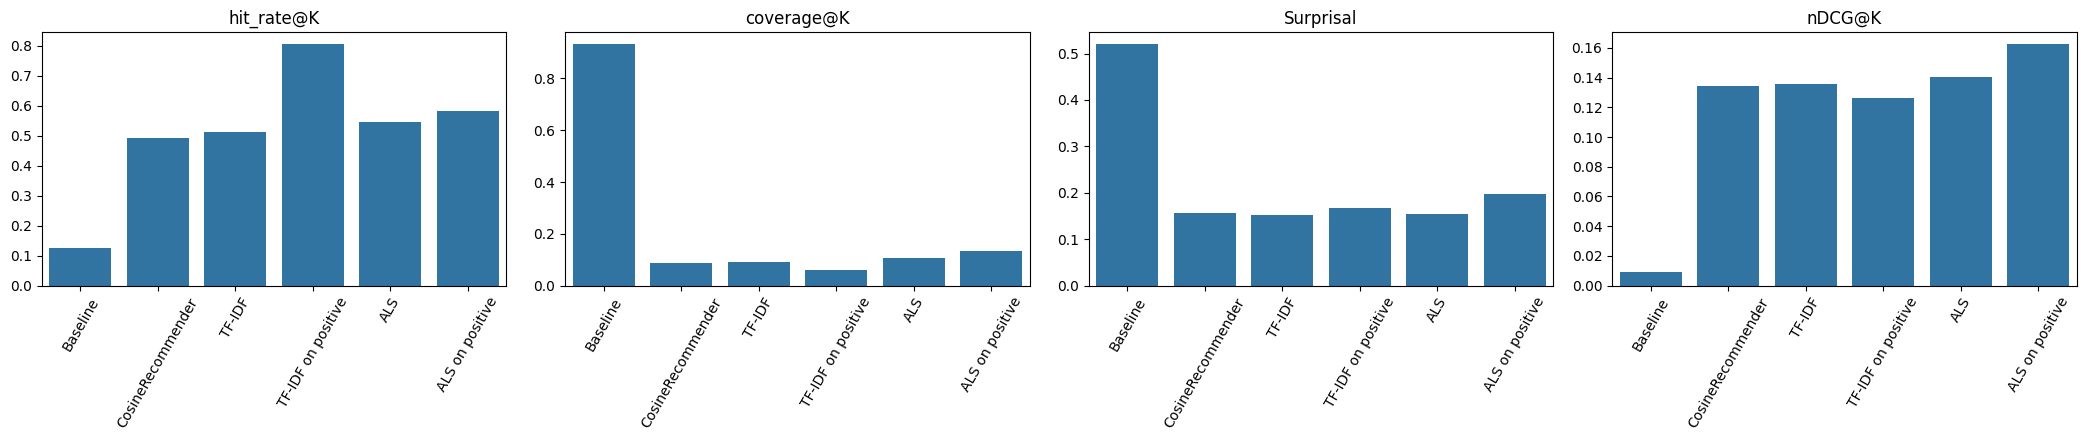

In [235]:
fig, axs = plt.subplots(ncols=4, figsize=(21, 4.5))

for ax, metrics in zip(axs.ravel(), rec_data.columns):
    sns.barplot(rec_data[metrics], ax=ax)
    ax.set_title(metrics)
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelrotation=60)

plt.tight_layout()

ALS справился на данном датасете лучше CosineRecommender и TF-IDF. Он более теоретически обоснованный. При этом на позитивных рекомендациях метрика NDCG@K лучше всего. Это вызвано тем, что NGCG@K работает без учета значения отзыва, а просто по фпкту его прибывания в выборках. Странно, что TF-IDF на позитивных значениях не дал прироста метрики, но это может быть связано с тем, что и разбиение было не совсем идеальным и сама логика метода больше идет в сторону увеличения Suprisal и hit_rate@K. Мы получили более частое угадывание хотя бы одного элемента. А это тоже хорошо для некоторых постановок задачи. Очень странно, что ALS выдает всего 3 и 5 факторов. На графиках видно, что тем самым мы рекомендуем всем примерно одно и то же. Возможно стоит взять больше валидационную выборку и сделать более умный подбор параметров, который учитывает не только метрику NDCG@K.